Setting up K-fold cross validation training...
EEG MOTOR IMAGERY CLASSIFICATION - K-FOLD CROSS VALIDATION DATA PREPARATION
CURRENT CONFIGURATION:
  subject: A01
  n_splits: 10
  random_seed: 42
  normalize: False
  num_corrupt: 0
  ratio_corrupt: 0
  if_train_corrupt: False
  data_dir: D:\Quentin\BMI\Experiment\2025Pub\06_MI_GAT\data\eeg_raw_dataset_0.5-40
Loading dataset from: D:\Quentin\BMI\Experiment\2025Pub\06_MI_GAT\data\eeg_raw_dataset_0.5-40
Loaded dataset: 9 subjects
Available subjects: ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09']
Data shape per subject: [n_samples, 22, 1000]
Data type: raw_signals
Total samples across all subjects: 4808

Dataset Information:
=== EEG Raw Signal Dataset Info ===
Subjects: 9 (A01, A02, A03, A04, A05, A06, A07, A08, A09)
Channels: 22
Timepoints per sample: 1000
Classes: 4
Sampling rate: 250 Hz
Sample duration: 4.00 seconds

Per-subject details:
  A01: 567 samples, classes [1 2 3 4] with counts [142 142 141 142]
  A02: 517 sample

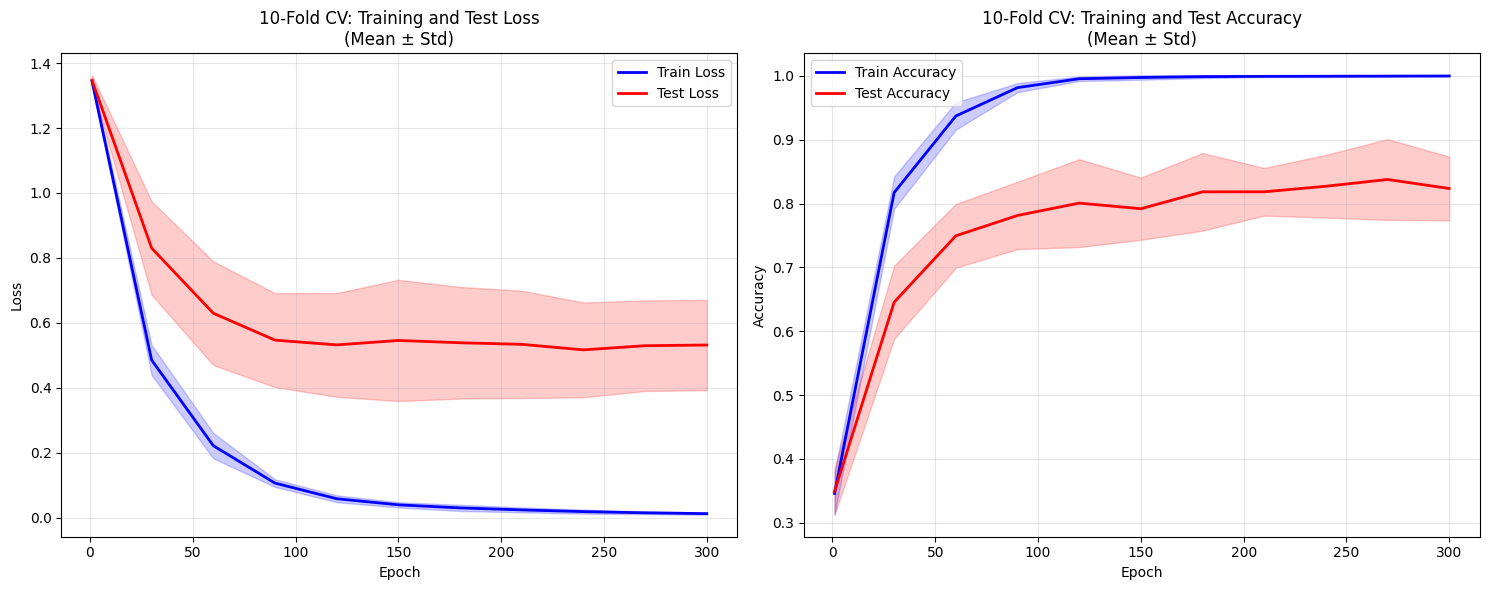

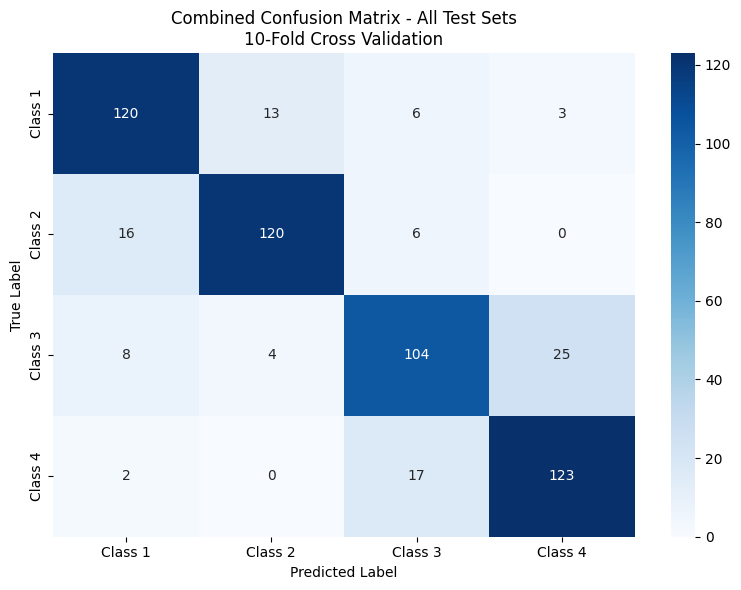


FINAL RESULTS - 10-FOLD CROSS VALIDATION
Subject: A01
Channel corruption: 1 channels
Corruption ratio: 100% of samples
Training set also corrupted: Yes
DWT reconstruction: Enabled (MSC connectivity)
Normalization: False
Test Set Metrics (10 folds):
  Accuracy:  82.36 ± 5.00 %
  F1-score:  0.8233 ± 0.0504
  AUC:       0.9625 ± 0.0142
  Kappa:     0.7648 ± 0.0666

Per-fold results:
  Fold 1: Acc=73.68%, F1=0.7366, AUC=0.9415, Kappa=0.6490
  Fold 2: Acc=89.47%, F1=0.8947, AUC=0.9836, Kappa=0.8597
  Fold 3: Acc=78.95%, F1=0.7820, AUC=0.9449, Kappa=0.7198
  Fold 4: Acc=82.46%, F1=0.8232, AUC=0.9702, Kappa=0.7661
  Fold 5: Acc=85.96%, F1=0.8592, AUC=0.9754, Kappa=0.8127
  Fold 6: Acc=80.70%, F1=0.8090, AUC=0.9610, Kappa=0.7426
  Fold 7: Acc=87.72%, F1=0.8768, AUC=0.9746, Kappa=0.8362
  Fold 8: Acc=75.00%, F1=0.7519, AUC=0.9520, Kappa=0.6667
  Fold 9: Acc=83.93%, F1=0.8402, AUC=0.9481, Kappa=0.7857
  Fold 10: Acc=85.71%, F1=0.8594, AUC=0.9732, Kappa=0.8095


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, cohen_kappa_score
import seaborn as sns
from utils import create_trainer
from model import CNNModel  # Import new CNN model
import random

# Import DWT reconstruction module
from DWT_reconstruct import (
    load_connectivity_matrices, 
    preprocess_data_with_dwt_reconstruction,
    DWT_CONFIG
)

# Data shape [n_samples, n_channels, n_timepoints]
# =================================================================
# CONFIGURATION - Modify parameters here
# =================================================================
CONFIG = {
    'subject': 'A01',              # 'all' or 'A01'-'A09'
    'n_splits': 10,                # Number of folds for K-fold cross validation
    'random_seed': 42,             # Random seed
    'normalize': False,            # Whether to normalize
    'num_corrupt': 1,              # Number of corrupted channels per sample in test set
    'ratio_corrupt': 100,          # Ratio of corrupted samples (0-100), e.g., 10 means 10% of samples are corrupted
    'if_train_corrupt': True,      # Whether to also corrupt training set channels
    'if_DWT_reconstruct': True,    # Whether to use DWT reconstruction for corrupted channels
    'Connec_type': 'MSC',          # Connectivity metric type: 'PCC' or 'MSC'
    'data_dir': '---YOUR PATH---\\eeg_raw_dataset_0.5-40'  # Dataset directory
}

# Training configuration
TRAINING_CONFIG = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'batch_size': 256,
    'learning_rate': 0.005,
    'weight_decay': 1e-4,
    'max_epochs': 300,
    'eval_interval': 30  # Evaluate every N epochs
}

# CNN model configuration
MODEL_CONFIG = {
    'f1': 8,                    # Output channels for first convolution layer
    'ke': 32,                   # Kernel size for first convolution layer
    'f2': 8,                    # Output channels for second convolution layer
    'num_classes': 4,           # Number of classes
    'dropout_prob': 0.3,        # Dropout probability
}

def set_seeds(seed):
    """Set all random seeds to ensure reproducibility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def evaluate(model, data_loader, criterion, device):
    """Evaluation function"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Get probability outputs
            probs = F.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    all_probs = np.vstack(all_probs)
    
    return avg_loss, accuracy, np.array(all_preds), np.array(all_labels), all_probs

def calculate_metrics(y_true, y_pred, y_probs, n_classes=4):
    """Calculate various evaluation metrics"""
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred) * 100
    
    # F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # AUC (using one-vs-rest method for multi-class)
    try:
        # Convert to one-hot encoding
        y_true_onehot = np.eye(n_classes)[y_true]
        auc = roc_auc_score(y_true_onehot, y_probs, multi_class='ovr')
    except:
        auc = np.nan
    
    # Kappa coefficient
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return accuracy, f1, auc, kappa

def train_single_fold(fold_idx, X_train_processed, X_test_processed, y_train, y_test, 
                     train_corruption_mask, test_corruption_mask, config, training_config, model_config):
    """Train a single fold"""
    print(f"\n{'='*20} FOLD {fold_idx+1} {'='*20}")
    
    # Set random seed
    set_seeds(config['random_seed'] + fold_idx)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_processed).to(training_config['device'])
    X_test_tensor = torch.FloatTensor(X_test_processed).to(training_config['device'])
    # Convert labels from 1-4 to 0-3 (PyTorch requirement)
    y_train_tensor = torch.LongTensor(y_train - 1).to(training_config['device'])
    y_test_tensor = torch.LongTensor(y_test - 1).to(training_config['device'])
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=training_config['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=training_config['batch_size'], shuffle=False)
    
    # Create CNN model
    num_channels = X_train_processed.shape[1]  # Number of EEG channels
    signal_length = X_train_processed.shape[2]  # Number of time points
    model = CNNModel(
        num_channels=num_channels,
        signal_length=signal_length,
        f1=model_config['f1'],
        ke=model_config['ke'],
        f2=model_config['f2'],
        num_classes=model_config['num_classes'],
        dropout_prob=model_config['dropout_prob']
    ).to(training_config['device'])
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), 
                          lr=training_config['learning_rate'],
                          weight_decay=training_config['weight_decay'])
    
    # Training history
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    # Print training information
    print(f"Training fold {fold_idx+1}...")
    if config['num_corrupt'] > 0 and config['ratio_corrupt'] > 0:
        n_train_corrupted = np.sum(np.any(train_corruption_mask, axis=1))
        n_test_corrupted = np.sum(np.any(test_corruption_mask, axis=1))
        print(f"  Training set: {n_train_corrupted} samples contain corrupted channels")
        print(f"  Test set: {n_test_corrupted} samples contain corrupted channels")
        if config['if_DWT_reconstruct']:
            print(f"  DWT reconstruction applied using {config['Connec_type']} connectivity")
    
    # Training loop
    for epoch in range(training_config['max_epochs']):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # Evaluate every specified epochs
        if (epoch + 1) % training_config['eval_interval'] == 0 or epoch == 0:
            # Evaluate training set and test set
            train_loss, train_acc, _, _, _ = evaluate(model, train_loader, criterion, training_config['device'])
            test_loss, test_acc, _, _, _ = evaluate(model, test_loader, criterion, training_config['device'])
            
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            test_losses.append(test_loss)
            test_accuracies.append(test_acc)
            
            # Print every eval_interval
            print(f"  Epoch [{epoch+1}/{training_config['max_epochs']}], "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    # Final evaluation
    print(f"Final evaluation for fold {fold_idx+1}:")
    train_loss, train_acc, train_preds, train_labels, train_probs = evaluate(model, train_loader, criterion, training_config['device'])
    test_loss, test_acc, test_preds, test_labels, test_probs = evaluate(model, test_loader, criterion, training_config['device'])
    
    # Calculate metrics
    train_metrics = calculate_metrics(train_labels, train_preds, train_probs)
    test_metrics = calculate_metrics(test_labels, test_preds, test_probs)
    
    print(f"  Train - Acc: {train_metrics[0]:.2f}%, F1: {train_metrics[1]:.4f}, "
          f"AUC: {train_metrics[2]:.4f}, Kappa: {train_metrics[3]:.4f}")
    print(f"  Test  - Acc: {test_metrics[0]:.2f}%, F1: {test_metrics[1]:.4f}, "
          f"AUC: {test_metrics[2]:.4f}, Kappa: {test_metrics[3]:.4f}")
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies,
        'train_metrics': train_metrics,
        'test_metrics': test_metrics,
        'test_preds': test_preds,
        'test_labels': test_labels,
        'fold_idx': fold_idx
    }

def plot_cv_results(cv_results, config):
    """Plot cross-validation results"""
    n_folds = len(cv_results)
    
    # Prepare data
    all_train_losses = []
    all_train_accuracies = []
    all_test_losses = []
    all_test_accuracies = []
    
    # Find maximum sequence length
    max_len = max(len(result['train_losses']) for result in cv_results)
    
    # Interpolate each fold's results to match length
    for result in cv_results:
        train_losses = result['train_losses']
        train_accuracies = result['train_accuracies']
        test_losses = result['test_losses']
        test_accuracies = result['test_accuracies']
        
        # If length differs, perform interpolation
        if len(train_losses) < max_len:
            # Simple linear interpolation
            x_old = np.linspace(0, 1, len(train_losses))
            x_new = np.linspace(0, 1, max_len)
            train_losses = np.interp(x_new, x_old, train_losses)
            train_accuracies = np.interp(x_new, x_old, train_accuracies)
            test_losses = np.interp(x_new, x_old, test_losses)
            test_accuracies = np.interp(x_new, x_old, test_accuracies)
        
        all_train_losses.append(train_losses)
        all_train_accuracies.append(train_accuracies)
        all_test_losses.append(test_losses)
        all_test_accuracies.append(test_accuracies)
    
    # Convert to numpy arrays
    all_train_losses = np.array(all_train_losses)
    all_train_accuracies = np.array(all_train_accuracies)
    all_test_losses = np.array(all_test_losses)
    all_test_accuracies = np.array(all_test_accuracies)
    
    # Calculate mean and standard deviation
    train_loss_mean = np.mean(all_train_losses, axis=0)
    train_loss_std = np.std(all_train_losses, axis=0)
    train_acc_mean = np.mean(all_train_accuracies, axis=0)
    train_acc_std = np.std(all_train_accuracies, axis=0)
    
    test_loss_mean = np.mean(all_test_losses, axis=0)
    test_loss_std = np.std(all_test_losses, axis=0)
    test_acc_mean = np.mean(all_test_accuracies, axis=0)
    test_acc_std = np.std(all_test_accuracies, axis=0)
    
    # Create x-axis (epochs)
    epochs = np.array([i * TRAINING_CONFIG['eval_interval'] for i in range(max_len)])
    epochs[0] = 1  # First point is epoch 1
    
    # Plot results
    plt.figure(figsize=(15, 6))
    
    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_mean, 'b-', label='Train Loss', linewidth=2)
    plt.fill_between(epochs, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, 
                     color='blue', alpha=0.2)
    plt.plot(epochs, test_loss_mean, 'r-', label='Test Loss', linewidth=2)
    plt.fill_between(epochs, test_loss_mean - test_loss_std, test_loss_mean + test_loss_std, 
                     color='red', alpha=0.2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{n_folds}-Fold CV: Training and Test Loss\n(Mean ± Std)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_mean, 'b-', label='Train Accuracy', linewidth=2)
    plt.fill_between(epochs, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, 
                     color='blue', alpha=0.2)
    plt.plot(epochs, test_acc_mean, 'r-', label='Test Accuracy', linewidth=2)
    plt.fill_between(epochs, test_acc_mean - test_acc_std, test_acc_mean + test_acc_std, 
                     color='red', alpha=0.2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{n_folds}-Fold CV: Training and Test Accuracy\n(Mean ± Std)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    # plt.savefig(f'cv_training_curves_{config["subject"]}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_combined_confusion_matrix(cv_results, config):
    """Plot combined confusion matrix for all test sets"""
    # Collect predictions and labels from all test sets
    all_test_preds = []
    all_test_labels = []
    
    for result in cv_results:
        all_test_preds.extend(result['test_preds'])
        all_test_labels.extend(result['test_labels'])
    
    all_test_preds = np.array(all_test_preds)
    all_test_labels = np.array(all_test_labels)
    
    # Create confusion matrix
    cm = confusion_matrix(all_test_labels, all_test_preds)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'],
                yticklabels=['Class 1', 'Class 2', 'Class 3', 'Class 4'])
    plt.title(f'Combined Confusion Matrix - All Test Sets\n{config["n_splits"]}-Fold Cross Validation')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    # plt.savefig(f'combined_confusion_matrix_{config["subject"]}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return all_test_preds, all_test_labels

def print_final_metrics(cv_results, config):
    """Print final statistical metrics"""
    n_folds = len(cv_results)
    
    # Collect test metrics from all folds
    test_accuracies = [result['test_metrics'][0] for result in cv_results]
    test_f1_scores = [result['test_metrics'][1] for result in cv_results]
    test_aucs = [result['test_metrics'][2] for result in cv_results]
    test_kappas = [result['test_metrics'][3] for result in cv_results]
    
    # Calculate mean and standard deviation
    acc_mean, acc_std = np.mean(test_accuracies), np.std(test_accuracies)
    f1_mean, f1_std = np.mean(test_f1_scores), np.std(test_f1_scores)
    auc_mean, auc_std = np.mean(test_aucs), np.std(test_aucs)
    kappa_mean, kappa_std = np.mean(test_kappas), np.std(test_kappas)
    
    print(f"\n{'='*60}")
    print(f"FINAL RESULTS - {n_folds}-FOLD CROSS VALIDATION")
    print(f"{'='*60}")
    print(f"Subject: {config['subject']}")
    print(f"Channel corruption: {config['num_corrupt']} channels")
    if config['ratio_corrupt'] > 0:
        print(f"Corruption ratio: {config['ratio_corrupt']}% of samples")
    else:
        print(f"Corruption ratio: 100% of samples")
    if config['if_train_corrupt']:
        print(f"Training set also corrupted: Yes")
    else:
        print(f"Training set also corrupted: No")
    if config['if_DWT_reconstruct']:
        print(f"DWT reconstruction: Enabled ({config['Connec_type']} connectivity)")
    else:
        print(f"DWT reconstruction: Disabled")
    print(f"Normalization: {config['normalize']}")
    print(f"{'='*60}")
    
    print(f"Test Set Metrics ({n_folds} folds):")
    print(f"  Accuracy:  {acc_mean:.2f} ± {acc_std:.2f} %")
    print(f"  F1-score:  {f1_mean:.4f} ± {f1_std:.4f}")
    print(f"  AUC:       {auc_mean:.4f} ± {auc_std:.4f}")
    print(f"  Kappa:     {kappa_mean:.4f} ± {kappa_std:.4f}")
    
    print(f"\nPer-fold results:")
    for i, result in enumerate(cv_results):
        metrics = result['test_metrics']
        print(f"  Fold {i+1}: Acc={metrics[0]:.2f}%, F1={metrics[1]:.4f}, "
              f"AUC={metrics[2]:.4f}, Kappa={metrics[3]:.4f}")
    
    return test_accuracies

"""Main training function"""
print("Setting up K-fold cross validation training...")

# Set initial random seed
set_seeds(CONFIG['random_seed'])

# Create trainer and prepare data
trainer = create_trainer(
    subject=CONFIG['subject'],
    n_splits=CONFIG['n_splits'],
    random_seed=CONFIG['random_seed'],
    normalize=CONFIG['normalize'],
    num_corrupt=0,  # Don't corrupt yet, handle uniformly later
    ratio_corrupt=0,
    if_train_corrupt=False,
    data_dir=CONFIG['data_dir']
)
success = trainer.run_data_preparation()

if not success:
    print("Data preparation failed!")
    exit(1)

# Get prepared cross-validation data
cv_data, scalers, cv_indices = trainer.get_data()

# Load connectivity matrices (if DWT reconstruction is enabled)
avg_conn_matrices = None
if CONFIG['if_DWT_reconstruct']:
    try:
        avg_conn_matrices = load_connectivity_matrices(CONFIG['subject'], CONFIG['Connec_type'])
        print(f"Successfully loaded {CONFIG['Connec_type']} connectivity matrices for DWT reconstruction")
    except Exception as e:
        print(f"Warning: Unable to load connectivity matrices: {e}")
        print("DWT reconstruction will be disabled")
        CONFIG['if_DWT_reconstruct'] = False

print(f"\nStarting {CONFIG['n_splits']}-fold cross validation training...")
print(f"Using device: {TRAINING_CONFIG['device']}")

# Store results from all folds
cv_results = []

# Train each fold
for fold_idx, (X_train, X_test, y_train, y_test) in enumerate(cv_data):
    print(f"\nPreparing data for fold {fold_idx+1}...")
    
    # Preprocess training set (if corruption is enabled)
    if CONFIG['if_train_corrupt'] and CONFIG['num_corrupt'] > 0 and CONFIG['ratio_corrupt'] > 0:
        X_train_processed, train_corruption_mask = preprocess_data_with_dwt_reconstruction(
            X_train, CONFIG, avg_conn_matrices, TRAINING_CONFIG['device']
        )
    else:
        X_train_processed = X_train
        train_corruption_mask = np.zeros((X_train.shape[0], X_train.shape[1]), dtype=bool)
    
    # Preprocess test set
    if CONFIG['num_corrupt'] > 0 and CONFIG['ratio_corrupt'] > 0:
        # Use different random seed for test set
        test_config = CONFIG.copy()
        test_config['random_seed'] = CONFIG['random_seed'] + 10000 + fold_idx
        X_test_processed, test_corruption_mask = preprocess_data_with_dwt_reconstruction(
            X_test, test_config, avg_conn_matrices, TRAINING_CONFIG['device']
        )
    else:
        X_test_processed = X_test
        test_corruption_mask = np.zeros((X_test.shape[0], X_test.shape[1]), dtype=bool)
    
    # Train single fold
    result = train_single_fold(fold_idx, X_train_processed, X_test_processed, y_train, y_test, 
                              train_corruption_mask, test_corruption_mask,
                              CONFIG, TRAINING_CONFIG, MODEL_CONFIG)
    cv_results.append(result)

# Plot cross-validation results
print(f"\n{'='*60}")
print("PLOTTING RESULTS")
print(f"{'='*60}")

# Plot training curves
plot_cv_results(cv_results, CONFIG)

# Plot combined confusion matrix
all_test_preds, all_test_labels = plot_combined_confusion_matrix(cv_results, CONFIG)

# Print final metrics
test_accuracies = print_final_metrics(cv_results, CONFIG)